In [1]:
import testing as t
from matplotlib import pyplot as plt
import joy_data_loader as loader
import numpy as np

## Fine tuning poem model on poems

In [1]:
!python fine_tune.py \
    --dataset_name Ozziey/poems_dataset\
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --do_train \
    --do_eval \
    --output_dir ./tmp/poem_baseline \
    --overwrite_output_dir

^C


## Fine tuning on Joy poems
https://huggingface.co/docs/transformers/v4.27.1/en/main_classes/trainer#transformers.TrainingArguments

In [ ]:
!python fine_tune.py \
    --dataset_name Ozziey/poems_dataset\
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --do_train \
    --do_eval \
    --num_train_epochs 50 \
    --seed 19019509 \
    --output_dir ./tmp/joy_poem_baseline \
    --overwrite_output_dir \
    --joy

## Finetune on PERC data
1. get data from: https://data.mendeley.com/datasets/n9vbc8g9cx/1
2. convert by running joy_data_loader.py
3. run following script

In [ ]:
!python fine_tune.py \
    --train_file ./Data/PERC.csv\
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --do_train \
    --do_eval \
    --num_train_epochs 50 \
    --seed 19019509 \
    --output_dir ./tmp/perc_poem_baseline \
    --overwrite_output_dir \
    --joy

## Generation

In [2]:
prompts = loader.load_evaluation_prompts(seed=1234567)
joy = prompts["joy"]
# this is for novelty evaluation
original = loader.load_evaluation_prompts(seed=1234567, length=-1)
joy_original = original["joy"]
joy_original

"To My Fairy Fancies NAY, no longer I may hold you, In my spirit's soft caresses, Nor like lotus-leaves enfold you In the tangles of my tresses. Fairy fancies, fly away To the white cloud-wildernesses, Fly away! Nay, no longer ye may linger With your laughter-lighted faces, Now I am a thought-worn singer In life's high and lonely places. Fairy fancies, fly away, To bright wind-inwoven spaces, Fly"

In [68]:
K=50

# change model path to the saved directory
!python text_generation.py \
    --model_type gpt2 \
    --model_name_or_path ./tmp/perc_poem_baseline \
    --length 100 \
    --prompt "$joy" \
    --seed 20 \
    --k $K \
    --num_return_sequences 250 >> ./Data/Generations/perc_generations.txt

03/24/2023 13:49:33 - WARNING - __main__ - device: cuda, n_gpu: 1, 16-bits training: False
03/24/2023 13:49:35 - INFO - __main__ - Namespace(device=device(type='cuda'), fp16=False, k=50, length=100, model_name_or_path='./tmp/perc_poem_baseline', model_type='gpt2', n_gpu=1, no_cuda=False, num_return_sequences=250, p=0.9, padding_text='', prefix='', prompt='To My Fairy Fancies NAY,', repetition_penalty=1.0, seed=20, stop_token=None, temperature=1.0, xlm_language='')
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Evaluation

### fluency

In [ ]:
rate, rates = t.fluency(verbose=1)

In [70]:
np.savetxt('./pre_computed/baseline_fluency_scores.txt', rates, delimiter=',') 

In [6]:
loaded = np.loadtxt('./pre_computed/baseline_fluency_scores.txt', delimiter=',') 
loaded.shape

(4999,)

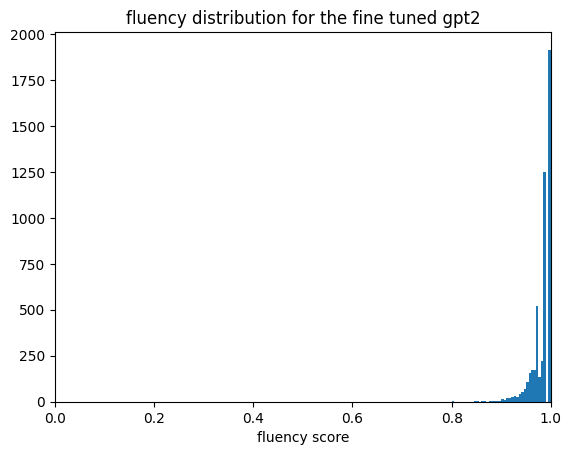

In [7]:

plt.close()
plt.figure()
plt.hist(loaded, bins=50)
plt.title("fluency distribution for the fine tuned gpt2")
plt.xlabel("fluency score")
plt.xlim(0, 1)
plt.show()


### Diversity

In [13]:
diversity = t.diversity(size=100)
np.savetxt('./pre_computed/baseline_diversity_scores.txt', diversity, delimiter=',') 

In [8]:
loaded_diversity = np.loadtxt('./pre_computed/baseline_diversity_scores.txt', delimiter=',') 
loaded_diversity.shape

(4950,)

0.3040137365476388 0.06432561170425977


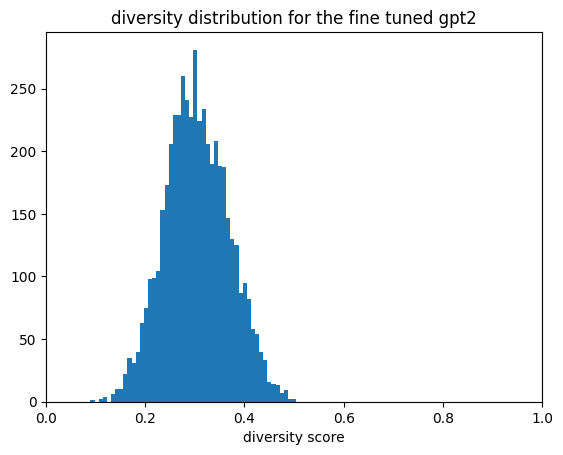

In [9]:
print(np.mean(loaded_diversity), np.std(loaded_diversity))
plt.figure()
plt.hist(loaded_diversity, bins=50)
plt.title("diversity distribution for the fine tuned gpt2")
plt.xlabel("diversity score")
plt.xlim(0, 1)
plt.show()

### Novelty

In [8]:
novelty = []
for i in range(40):
    novelty.append(t.novelty(training_phrase=joy_original, size=100, start=i*100))

np.savetxt('./pre_computed/baseline_novelty_scores.txt', novelty, delimiter=',') 

In [10]:
loaded_novelty = np.loadtxt('./pre_computed/baseline_novelty_scores.txt', delimiter=',') 
loaded_novelty = loaded_novelty.flatten()
loaded_novelty.shape

(4040,)

0.31110519542598564 0.06046361136202341


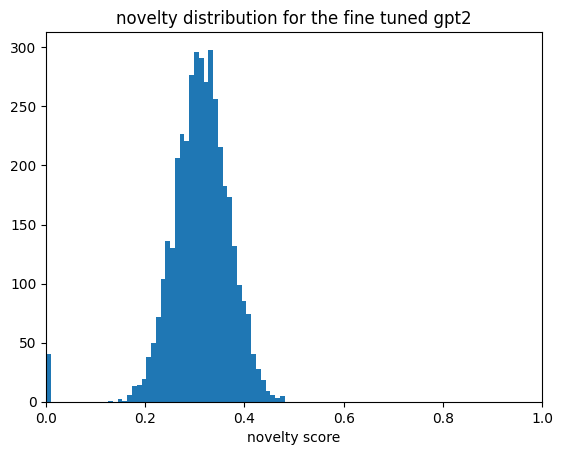

In [11]:
print(np.mean(loaded_novelty), np.std(loaded_novelty))
plt.figure()
plt.hist(loaded_novelty, bins=50)
plt.title("novelty distribution for the fine tuned gpt2")
plt.xlabel("novelty score")
plt.xlim(0,1)
plt.show()

### Sentiment accuracy

In [3]:
pos_score, neg_score = t.accuracy_smooth()
np.savetxt('./pre_computed/baseline_sentiment_scores.txt', pos_score, delimiter=',') 
np.savetxt('./pre_computed/baseline_sentiment_neg_scores.txt', neg_score, delimiter=',') 

5000  phrases


0.2770051553409081 0.4273106040422834


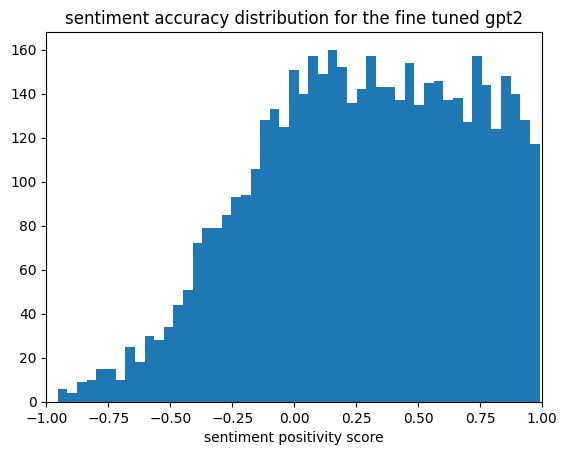

In [7]:
pos_score = np.loadtxt('./pre_computed/baseline_sentiment_scores.txt', delimiter=',') 
neg_score = np.loadtxt('./pre_computed/baseline_sentiment_neg_scores.txt', delimiter=',') 
sentiment_accuracy = pos_score - neg_score
print(np.mean(sentiment_accuracy), np.std(sentiment_accuracy))
plt.figure()
plt.hist(sentiment_accuracy, bins=50)
plt.title("sentiment accuracy distribution for the fine tuned gpt2")
plt.xlim(-1, 1)
plt.xlabel("sentiment positivity score")
plt.show()

#### RL sentiment

In [4]:
rl_pos_score, rl_neg_score = t.accuracy_smooth(path="./Data/Generations/test.txt")
np.savetxt('./pre_computed/rl_sentiment_scores.txt', rl_pos_score, delimiter=',') 
np.savetxt('./pre_computed/rl_sentiment_neg_scores.txt', rl_neg_score, delimiter=',') 

5000  phrases


0.6779475952729 0.3502540321257662


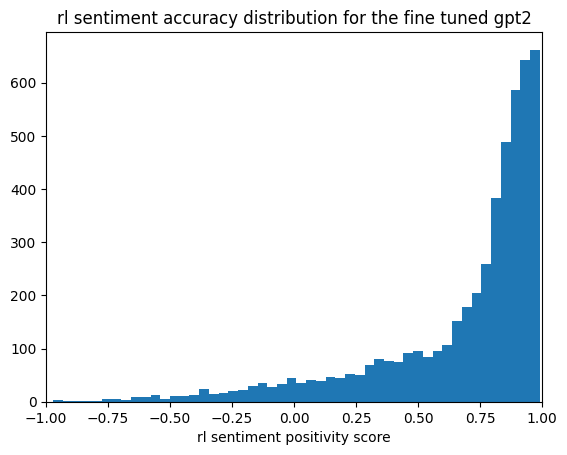

In [8]:
rl_pos_score = np.loadtxt('./pre_computed/rl_sentiment_scores.txt', delimiter=',') 
rl_neg_score = np.loadtxt('./pre_computed/rl_sentiment_neg_scores.txt', delimiter=',') 
rl_sentiment_accuracy = rl_pos_score-rl_neg_score
print(np.mean(rl_sentiment_accuracy), np.std(rl_sentiment_accuracy))
plt.figure()
plt.hist(rl_sentiment_accuracy, bins=50)
plt.title("rl sentiment accuracy distribution for the fine tuned gpt2")
plt.xlabel("rl sentiment positivity score")
plt.xlim(-1, 1)
plt.show()